## Experimenting with Multi-Label Neural Net Classifier

Import Statement

In [110]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import os

Verify GPU Availability

In [111]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


Use the gpu

In [112]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        print(e)

Constants

In [113]:
data_path = '../data/processed/final.csv'
print(os.path.exists(data_path))

True


Load the data

In [114]:
df = pd.read_csv(data_path)

Print our the columns and define the features and taregts within a list

In [115]:
df.columns

Index(['id', 'home_team', 'away_team', 'home_score', 'away_score', 'result',
       'home_attack_strength', 'home_defence_strength', 'away_attack_strength',
       'away_defence_strength', 'home_score_avg', 'away_score_avg',
       'home_expected_goal', 'away_expected_goal', 'home_elo', 'away_elo', '1',
       '2', 'x', '12', '1x', '2x', 'ov0.5', 'un0.5', 'ov1.5', 'un1.5', 'ov2.5',
       'un2.5', 'ov3.5', 'un3.5', 'ov4.5', 'un4.5', 'num_home_games',
       'num_away_games', 'home_win', 'away_win', 'home_double', 'away_double',
       'under0.5', 'under1.5', 'under2.5', 'under3.5', 'under4.5', 'draw'],
      dtype='object')

In [116]:
FEATURES = ['home_attack_strength', 'home_defence_strength', 'away_attack_strength',
           'away_defence_strength', 'home_expected_goal', 'away_expected_goal']
# TARGETS = ['home_win' , 'draw' , 'away_win' , 'home_double' , 'away_double']
# TARGETS = ['home_win' , 'draw' , 'away_win' , 'under0.5' , 'under1.5' , 'under2.5' , 'under3.5']
TARGETS = ['home_win' , 'draw' , 'away_win']


Drop games with less than 3 matches by each teams

In [117]:
min_games = 5
df = df[(df['num_home_games'] >= min_games) & (df['num_away_games'] >= min_games)]

Select the relevant columns only, i.e features and targets

In [118]:
cols = [*FEATURES , *TARGETS]
drop_cols = [col for col in df.columns if col not in cols]

df = df.drop(columns=drop_cols)

Remove na values

In [119]:
null_holder = df.isna().sum().to_dict()
null_holder

{'home_attack_strength': 0,
 'home_defence_strength': 0,
 'away_attack_strength': 0,
 'away_defence_strength': 0,
 'home_expected_goal': 0,
 'away_expected_goal': 0,
 'home_win': 0,
 'away_win': 0,
 'draw': 0}

In [120]:
df = df.dropna()

In [121]:
null_holder = df.isna().sum().to_dict()
null_holder

{'home_attack_strength': 0,
 'home_defence_strength': 0,
 'away_attack_strength': 0,
 'away_defence_strength': 0,
 'home_expected_goal': 0,
 'away_expected_goal': 0,
 'home_win': 0,
 'away_win': 0,
 'draw': 0}

In [122]:
df.shape

(402425, 9)

Separate the target values from the features values

In [123]:
x_values = df.drop(columns=TARGETS)
y_values = df.drop(columns=FEATURES)

Split the data into training , validation and testing sets. 80 - 10 - 10 

In [124]:
# first split the data into two parts , 80 - 20 , the 80 will be the training set
x_train , x_remaining , y_train , y_remaining = train_test_split(x_values , y_values , test_size=.2 , random_state=7)

# now split the remaining data into two parts , 50 - 50 , which will result in 10% for both validation set and testing set
x_validation , x_test , y_validation , y_test = train_test_split(x_remaining , y_remaining , test_size=.5 , random_state=7)  

Normalize the data

In [125]:
from sklearn import preprocessing

normalizer = preprocessing.Normalizer()

# normalize the training data
x_train = normalizer.fit_transform(x_train)

# normalize the validation data
x_validation = normalizer.transform(x_validation)

Building the neural network

In [126]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(len(FEATURES),)))
model.add(tf.keras.layers.Dense(units=128 , activation='relu'))
model.add(tf.keras.layers.Dense(units=128 , activation='relu'))
model.add(tf.keras.layers.Dense(units=64 , activation='relu'))
model.add(tf.keras.layers.Dense(units=32 , activation='relu'))
model.add(tf.keras.layers.Dense(units=len(TARGETS) , activation='softmax'))

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.01,   
    beta_1=0.9,             
    beta_2=0.999,           
    epsilon=1e-4            
)

model.compile(optimizer=optimizer , loss='categorical_crossentropy' , metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 128)               896       
                                                                 
 dense_21 (Dense)            (None, 128)               16512     
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 dense_23 (Dense)            (None, 32)                2080      
                                                                 
 dense_24 (Dense)            (None, 3)                 99        
                                                                 
Total params: 27,843
Trainable params: 27,843
Non-trainable params: 0
_________________________________________________________________


In [127]:
log_path = '/logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_path)
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    min_delta = 1e-7,
    patience=5,
    mode='auto',
    verbose=1,
    restore_best_weights=True
)

Training the Model

In [128]:
training_history = model.fit(x=x_train , y=y_train , batch_size=128 , validation_data=(x_validation , y_validation) , callbacks=[tensorboard_callback , earlystop_callback] , epochs=30)

Epoch 1/30
2516/2516 [==============================] - 7s 3ms/step - loss: 0.9889 - accuracy: 0.5267 - val_loss: 0.9867 - val_accuracy: 0.5261
Epoch 2/30
2516/2516 [==============================] - 6s 2ms/step - loss: 0.9864 - accuracy: 0.5275 - val_loss: 0.9863 - val_accuracy: 0.5251
Epoch 3/30
2516/2516 [==============================] - 6s 2ms/step - loss: 0.9855 - accuracy: 0.5282 - val_loss: 0.9887 - val_accuracy: 0.5254
Epoch 4/30
2516/2516 [==============================] - 6s 2ms/step - loss: 0.9857 - accuracy: 0.5283 - val_loss: 0.9891 - val_accuracy: 0.5229
Epoch 5/30
2516/2516 [==============================] - 6s 2ms/step - loss: 0.9852 - accuracy: 0.5285 - val_loss: 0.9868 - val_accuracy: 0.5248
Epoch 6/30
2516/2516 [==============================] - 6s 2ms/step - loss: 0.9849 - accuracy: 0.5287 - val_loss: 0.9861 - val_accuracy: 0.5257
Epoch 7/30
2516/2516 [==============================] - 6s 2ms/step - loss: 0.9848 - accuracy: 0.5287 - val_loss: 0.9869 - val_accuracy:

Plot the loss and accuracy graphs

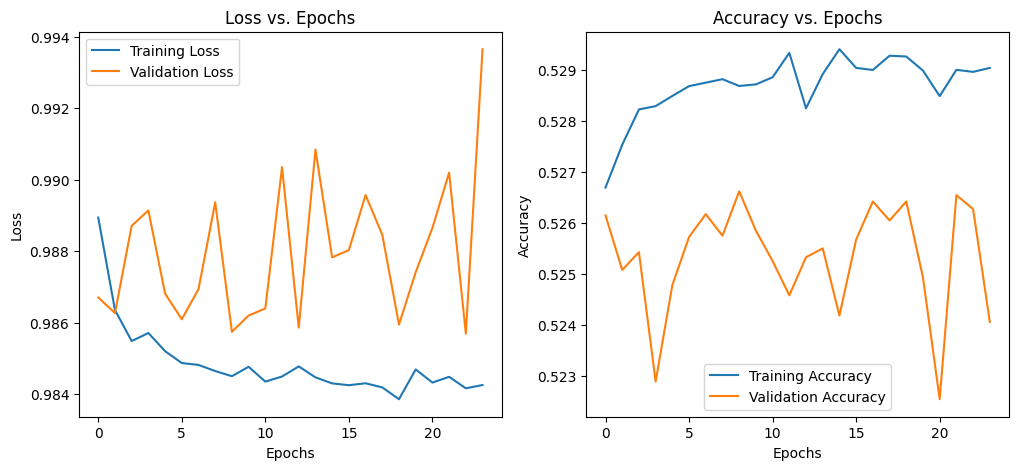

In [129]:
import matplotlib.pyplot as plt

# Extract loss and accuracy from the training history
train_loss = training_history.history['loss']
val_loss = training_history.history['val_loss']
train_accuracy = training_history.history['accuracy']
val_accuracy = training_history.history['val_accuracy']

# Plotting loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Test the model

In [130]:
# normalize the test data
x_test = normalizer.transform(x_test)

predictions = model.predict(x=x_test)

1258/1258 [==============================] - 1s 950us/step


In [131]:
import numpy as np
max_indices = np.argmax(predictions, axis=1)
one_hot_encodings = np.zeros_like(predictions)
one_hot_encodings[np.arange(predictions.shape[0]), max_indices] = 1

In [132]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test , one_hot_encodings)

In [133]:
accuracy

0.5277936535546555

In [134]:
predictions = pd.DataFrame(predictions)
print(predictions)

              0         1         2
0      0.503310  0.245935  0.250755
1      0.571684  0.208990  0.219326
2      0.341746  0.408846  0.249409
3      0.347318  0.401937  0.250745
4      0.198644  0.604774  0.196582
...         ...       ...       ...
40238  0.607881  0.190622  0.201498
40239  0.482918  0.264297  0.252785
40240  0.557288  0.216326  0.226385
40241  0.375536  0.367721  0.256743
40242  0.251677  0.527766  0.220557

[40243 rows x 3 columns]


In [135]:
print(y_test)

        home_win  away_win  draw
222534         1         0     0
492925         0         1     0
607224         1         0     0
624285         0         0     1
440333         1         0     0
...          ...       ...   ...
273560         1         0     0
419783         0         0     1
276670         0         1     0
35010          0         1     0
271993         0         1     0

[40243 rows x 3 columns]


Now let us train the model on the remaining 